## Traitement de données des observations:

Commençons par importer numpy

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

A l'aide du logiciel Iris, nous avons pu utiliser les images enregistrées par le télescope T5 pour en déduire le flux de lumière de notre étoile AH Vir (Vmax=8.890 mag) ainsi que celle de notre étoile de comparaison HD 106815 (V=9.38 mag). 
Bien que le logiciel utilise une unité arbitraire (ADU), nous allons simplement utiliser le rapport entre les deux flux ainsi que la définition de magnitude apparente pour déterminer la magnitude de AH Vir à une phase donnée.
    
    
$$\begin{equation}
m_{HD 106815} - m_{AH Vir}=-2.5 \cdot \log\left(\frac{f_{HD 106815}}{f_{AH Vir}}\right)
\end{equation}$$

Commençons par créer une routine qui permet de déterminer la magnitude apparente de notre étoile. Ayant fait 5 observations par phases, nous allons également en profiter pour calculer la magnitude moyenne de chaque phase.


In [2]:
def mag_finder(Fvir,Fcomp,phases):
#--------------------------------------- Constantes et listes vides
    mcomp=9.38     #Magnitude apparente de HD 106815
    Mvir=[]        #Liste allant stocker les magnitudes apparentes de AH Vir (5 par phase)
    Means=[]       #Liste allant stocker les moyennes de chaque phase
#--------------------------------------- Routine principale
    for i in range (len(phases)): #i va compter le nombre de phases
        Mvir.append([])           #On crée une liste dans Magnitude Vir pour chaque phase
        print('Phase %s:'%(phases[i]))      #Cette étape ne sert que pour présenter les résultats pour une phase donnée
        for j in range(len(Fvir[i])):     #Cette boucle va nous calculer la magnitude pour chaque observation
            Mvir[i].append(mcomp+2.5*np.log10(Fcomp[i][j]/Fvir[i][j]))
            print('\n', Mvir[i][j])       #Nous retournons la j^ème observation de la phase i
        Means.append(np.mean(Mvir[i]))       #Nous faisons la moyenne la phase i
        print("Magnitude moyenne:",Means[i])                   #Nous retournons enfin chaque moyenne
    return(Means)

In [6]:
Fvir = [[108270.0, 107773.0, 112423.0, 111360.0, 113026.0],
        [98716.0, 98713.0, 97501.0, 97782.0, 98348.0],
        [71043.0, 70982.0, 72328.0, 71254.0, 71979.0],
        [94836.0, 93492.0, 95705.0, 94759.0, 95687.0],
        [104809.0, 104274.0, 102768.0, 102573.0, 95269.0],
        [109557.0, 109874.0, 110211.0, 111547.0, 110392.0],
        [92840.0, 98088.0, 96153.0, 89407.0, 96309.0],
        [72768.0, 72167.0, 72485.0, 71975.0, 72245.0],
        [81503.0, 82357.0, 84309.0, 83274.0, 83617.0],
        [102233.0, 103113.0, 103302.0, 104388.0, 103669.0]]

Fcomp = [[77425.0, 76746.0, 76913.0, 76106.0, 76552.0],
         [77668.0, 77791.0, 77187.0, 77976.0, 76952.0],
         [79183.0, 80957.0, 80231.0, 81078.0, 79718.0],
         [80870.0, 83256.0, 82729.0, 82534.0, 81540.0],
         [77798.0, 77951.0, 75128.0, 77109.0, 73263.0],
         [76398.0, 76603.0, 76501.0, 76267.0, 76652.0], 
         [77267.0, 77459.0, 76059.0, 77475.0, 77463.0],
         [74709.0, 76043.0, 75814.0, 76404.0, 75922.0],
         [75394.0, 75083.0, 74800.0, 75063.0, 75563.0],
         [78298.0, 79093.0, 78707.0, 78166.0, 79153.0]]

phases = [0.0, 0.1875, 0.3125, 0.375, 0.4375, 0.5, 0.6875, 0.75, 0.875, 0.9375]

M_AHVir = mag_finder(Fvir,Fcomp,phases)
print(M_AHVir)

Phase 0.0:

 9.015932693124137

 9.011364442871788

 8.96786145289851

 8.96672418626589

 8.956945458551981
Magnitude moyenne: 8.98376564674246
Phase 0.1875:

 9.119636431575286

 9.121387508879241

 9.12633772927242

 9.134255092813216

 9.113635947930776
Magnitude moyenne: 9.123050542094187
Phase 0.3125:

 9.497776648215897

 9.522765435839986

 9.49258937262934

 9.520234444270017

 9.490876464160747
Magnitude moyenne: 9.504848473023198
Phase 0.375:

 9.207035537809418

 9.25410272789269

 9.221807867898185

 9.230031061799739

 9.20629442104331
Magnitude moyenne: 9.223854323288668
Phase 0.4375:

 9.056424637838594

 9.064114143340438

 9.039859807172462

 9.070180033081241

 9.094832729281233
Magnitude moyenne: 9.065082270142792
Phase 0.5:

 8.988604645012725

 8.988377106953093

 8.983605422968466

 8.967196922225844

 8.983964723222558
Magnitude moyenne: 8.982349764076536
Phase 0.6875:

 9.180647296735293

 9.123640016242824

 9.125469430629495

 9.224475155714641

 9.1435685972

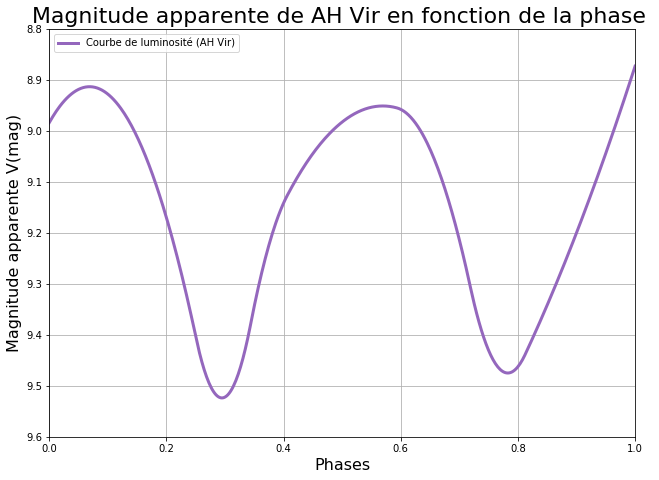

In [8]:
Mag, Phases = np.array(M_AHVir), (np.array(phases))
#sigma=np.array([,])
#--------------------------------------------------------------------------------- Graphe
PhasesNew = np.linspace(0, 1, 500) 
spl = make_interp_spline(Phases, Mag, k=2)  # type: BSpline
function_smooth = spl(PhasesNew)

plt.figure(figsize=(10.5,7.5))
plt.title('Magnitude apparente de AH Vir en fonction de la phase ', size=22)
plt.xlabel('Phases', size=16)
plt.ylabel('Magnitude apparente V(mag)', size=16)
plt.plot(PhasesNew,function_smooth, "-", label='Courbe de luminosité (AH Vir)',
            color='C4', linewidth=3)
#plt.errorbar(Phases,Mag,xerr=0,yerr=sigma, label='Erreurs',
#            color='C0', linestyle='' ,linewidth=2)
plt.legend(loc='upper left')
plt.xlim(0.,1.)
plt.ylim(9.6,8.8)
plt.grid()